In [1]:
import numpy as np
import torch
from sudoku import Sudoku
from deep_sudoku.utils import sudoku_utils, data_utils

In [2]:
data_utils.split_data()
train_sudokus, val_sudokus, test_sudokus = data_utils.load_data()

In [62]:
board = train_sudokus[0][0]
solved = train_sudokus[0][1]
rng = np.random.default_rng()

In [70]:
0, 81-17

(0, 64)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv0 = nn.Conv2d(in_channels = 1, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        
        self.convs = []
        for i in range(8):
            self.convs.append(nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1))
        self.convs = nn.ModuleList(self.convs)
        
        self.convlast = nn.Conv2d(in_channels =128, out_channels = 9, kernel_size = 3, stride = 1, padding = 1)
    
    def forward(self, x):   
        x = self.conv0(x)
        x = nn.ReLU()(x)
        for conv in self.convs:
            x = conv(x)
            x = nn.ReLU()(x)
        x = self.convlast(x)
        return x
        
    

In [55]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)
x_train = torch.tensor(x_train.reshape(-1,1,9,9).astype('float32'))
y_train = torch.tensor(y_train - 1).type(torch.LongTensor)

In [56]:
x_train, y_train = data_utils.generate_batch(train_sudokus)
x_train = torch.tensor(x_train.reshape(-1,1,9,9).astype('float32'))
y_train = torch.tensor(y_train - 1).type(torch.LongTensor)

In [57]:
x_val, y_val = data_utils.generate_batch(val_sudokus, augment = False)
x_val = torch.tensor(x_val.reshape(-1,1,9,9).astype('float32')).cuda()
y_val = torch.tensor(y_val - 1).type(torch.LongTensor).cuda()

In [ ]:
from time import time
model = simpleNet()
model.to('cuda')
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

val_losses = []
losses = []

min_val_loss = 100

# # load the model checkpoint
# checkpoint = torch.load('./documentation/models/2/model.pth')
# # load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
# print('Previously trained model weights state_dict loaded...')
# # load trained optimizer state_dict
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# print('Previously trained optimizer state_dict loaded...')
# start_epoch = checkpoint['epoch']
# # load the criterion
# loss = checkpoint['loss']
# print('Trained model loss function loaded...')
# min_val_loss = loss

for epoch in range(0, 5000):
    model.train()
    x_train, y_train = data_utils.fast_generate_batch(train_sudokus)
    x_train = torch.tensor(x_train.reshape(-1,1,9,9).astype('float32'))
    y_train = torch.tensor(y_train - 1).type(torch.LongTensor)
    x_train = x_train.cuda()
    y_train = y_train.cuda()
    
    y_pred = model(x_train)
    y_pred = y_pred.cuda()
    
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        y_pred_val = model(x_val)
        val_loss = loss_fn(y_pred_val, y_val)
        
    val_losses.append(val_loss.item())
    losses.append(loss.item())
    
    if (epoch % 100) == 0:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, './documentation/models/2/epoch%d_loss%.3f.pth' % (epoch,val_loss))
    if val_loss < min_val_loss:
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                    }, './documentation/models/2/best.pth')
        min_val_loss = val_loss
        
    print(f'Epoch {epoch}, loss = {loss.item():.4f}, validation loss = {val_loss.item():.4f}.', end = "\r")
    
    
    

In [63]:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, './documentation/models/2/model.pth')

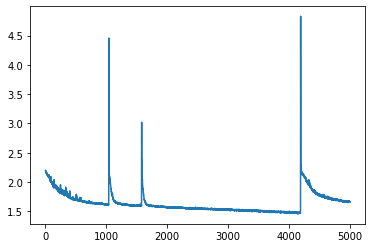

In [16]:
plt.plot(losses)

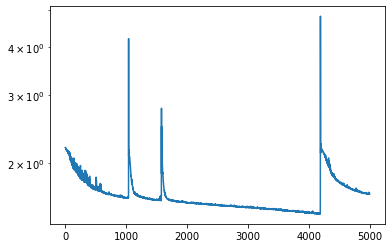

In [18]:
plt.semilogy(val_losses)

In [19]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)


In [20]:
x_train[0]

array([[0, 0, 0, 7, 0, 0, 0, 0, 0],
       [0, 0, 0, 5, 0, 8, 0, 0, 9],
       [6, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 1, 5],
       [0, 0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 9, 0, 0, 0, 4, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 8],
       [0, 0, 0, 0, 6, 1, 0, 0, 0]], dtype=uint8)

In [21]:
x_train, y_train = data_utils.fast_generate_batch(train_sudokus)


In [35]:
x_train[0]

tensor([[[0., 0., 0., 7., 0., 9., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 6.],
         [0., 0., 0., 0., 0., 0., 1., 2., 8.],
         [0., 0., 0., 0., 0., 5., 0., 0., 0.],
         [0., 2., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 4., 1., 3., 0., 0.],
         [0., 0., 0., 2., 8., 0., 0., 0., 0.],
         [3., 0., 0., 0., 0., 0., 0., 9., 0.],
         [0., 0., 1., 0., 0., 0., 4., 0., 0.]]])

In [36]:
y_train[0]

tensor([[5, 7, 1, 6, 0, 8, 4, 2, 3],
        [3, 0, 2, 7, 4, 1, 8, 6, 5],
        [6, 4, 8, 3, 2, 5, 0, 1, 7],
        [0, 2, 5, 8, 1, 4, 7, 3, 6],
        [4, 1, 3, 2, 6, 7, 5, 0, 8],
        [7, 8, 6, 5, 3, 0, 2, 4, 1],
        [8, 3, 4, 1, 7, 2, 6, 5, 0],
        [2, 6, 7, 0, 5, 3, 1, 8, 4],
        [1, 5, 0, 4, 8, 6, 3, 7, 2]])

In [46]:
np.argwhere(y_pred[0,:,0,:].cpu() > -0.2)

tensor([[0, 2, 4, 6, 6, 6, 7, 8, 8, 8],
        [3, 5, 8, 4, 6, 8, 4, 3, 4, 8]])

In [41]:
y_pred[0].cpu().shape

torch.Size([9, 9, 9])

In [51]:
y_pred[0,:,0,8]

tensor([-0.9362, -4.6014, -0.5402, -0.2921,  0.2304, -0.3378, -0.1828, -0.4231,
         0.0343], device='cuda:0', grad_fn=<SelectBackward>)

In [52]:
torch.save(model, "documentation/models/1/state_dict.pt")

PicklingError: Can't pickle <class '__main__.simpleNet'>: it's not the same object as __main__.simpleNet